In [1]:
import time
import json
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
from IPython import display
from matplotlib import pyplot as plt
from matplotlib.text import Text
%matplotlib inline

# Settings

In [2]:
meta_dir = "D:\\math\\res12.04.2019T06_56_23"
data_dir = "D:\\math\\res12.04.2019T06_56_23"
fourier_dir = "D:\\rk smooth fourier"
pic_dir = ""

def set_lineplot():
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['grid.color'] = 'gray'  
    plt.rcParams['axes.grid'] = True
    plt.rcParams['lines.linewidth'] = 5
    plt.rcParams['font.size'] = 24

def set_heatmap():
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.figsize'] = [20, 10]

# Drawing

In [3]:
class Draw:
    def heatmap(df,start,end,xticks,xticklabels,cmap,transpose = False,save_path = ''):       
        plt.clf()
        plt.cla()
        df = pd.DataFrame(df.iloc[start:end])
        if transpose:
            df = df.transpose()
        pic = sns.heatmap(df,xticklabels=False,yticklabels=False,cmap=cmap,cbar_kws = dict(use_gridspec=False,location="top"))
        pic.set_xticks(xticks)
        pic.set_xticklabels(xticklabels)
        if save_path == '':
            plt.show()
        else:
            plt.savefig(save_path)    
        del df

# Data wrapper

In [96]:
class Result:
    def __init__(self,_id):
        onlyfiles = [os.path.join(meta_dir, f) for f in os.listdir(meta_dir) if os.path.isfile(os.path.join(meta_dir, f))]
        path_to_meta = next(filter(lambda x: _id in x and '_meta' in x,onlyfiles))
        with open(path_to_meta,'r') as f:
            lines = f.readlines()
            self.meta = json.loads(lines[0])
            self.end_u = np.fromstring(lines[1][1:-2],sep=',',dtype=np.float)
            self.end_v = np.fromstring(lines[2][1:-2],sep=',',dtype=np.float)
            self.start_u = np.array(self.meta['InitStateU'],dtype = np.float)
            del self.meta['InitStateU']
            self.start_v = np.array(self.meta['InitStateV'],dtype = np.float)
            del self.meta['InitStateV']
            self.meta['TimeLineQuant']*=self.meta['TimeQuant']
            self.space_net = np.fromiter([i * self.meta['SpaceQuant'] for i in range(0,int(self.meta['SpaceRange']/self.meta['SpaceQuant']))],dtype=np.float)
    def draw_end_u(self):
        set_lineplot()
        sns.lineplot(self.space_net, self.end_u)
    def draw_start_u(self):
        set_lineplot()
        sns.lineplot(self.space_net, self.start_u)
    def draw_end_v(self):
        set_lineplot()
        sns.lineplot(self.space_net, self.end_v)
    def draw_start_v(self):
        set_lineplot()
        sns.lineplot(self.space_net, self.start_v)
    def draw_heatmap(self,start, end,x_freq, cmap = 'cividis', display = True):
        set_heatmap()
        plt.clf()
        onlyfiles = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
        path_to_data = next(filter(lambda x: str(self.meta['Id']) in x and '_data' in x,onlyfiles))
        data = pd.read_csv(path_to_data,sep=';',dtype=np.float)
        start_scaled = max(0,int(start/self.meta['TimeLineQuant']))
        end_scaled = min(int(end/self.meta['TimeLineQuant']),len(data.index)-1)
        if display:
            savepath = ''
        else:
            savepath = pic_dir+'\\'+str(self.meta['Id'])+'_'+str(start)+'_'+str(end)+'.png'
        x_freq_scaled = int(x_freq/self.meta['TimeLineQuant'])
        xticks = np.linspace(0,(end_scaled-start_scaled) - (end_scaled-start_scaled)%x_freq_scaled,x_freq+1,dtype=np.int)
        xticklabels = np.array([int(x*self.meta['TimeLineQuant']+start) for x in xticks])#np.linspace(start,end - end%x_freq,x_freq+1,dtype=np.int)
        Draw.heatmap(data,start_scaled,end_scaled,xticks,xticklabels,cmap,True,savepath)
    def draw_fourier(self,start,end,namestart,nameend):
        set_lineplot()
        start_scaled = int(start/self.meta['TimeLineQuant'])
        end_scaled = int(end/self.meta['TimeLineQuant'])
        onlyfiles = [os.path.join(fourier_dir, f) for f in os.listdir(fourier_dir) if os.path.isfile(os.path.join(fourier_dir, f))]
        path_to_data = next(filter(lambda x: str(self.meta['Id']) in x and '_Fourier' in x,onlyfiles))
        if not hasattr(self,'data'):
            self.data = pd.read_csv(path_to_data,sep=' ',dtype=float)
        start_scaled = max(0,int(start/self.meta['TimeLineQuant']))
        end_scaled = min(int(end/self.meta['TimeLineQuant']),len(self.data.index)-1)
        data = self.data.loc[:,namestart:nameend].iloc[start_scaled:end_scaled]
        pic = data.drop(data.columns.values[-1],axis=1).plot.line(color = sns.color_palette("colorblind",len(data)),legend=False)
        pic.legend()
        pic.set_xlim(start_scaled,end_scaled)
        plt.show()
def get_kok(num):
    i = 0
    while num > 0:
        num = num // 10
        i+=1
    return i

In [87]:
get_kok(100)

3

In [97]:
a = Result(os.path.join(meta_dir,'-1478802681'))

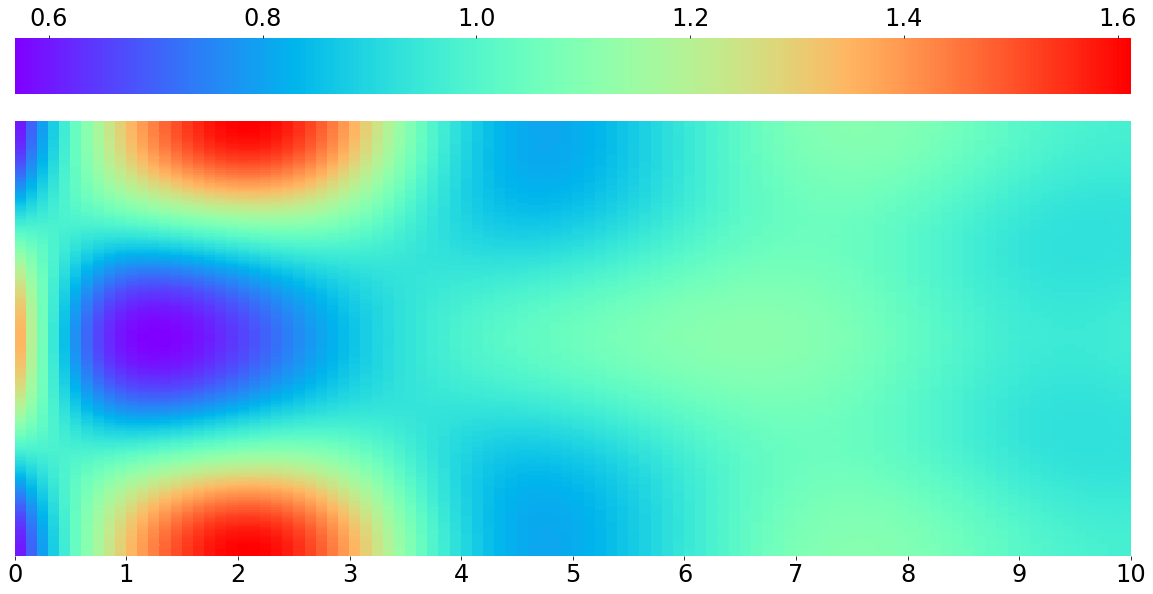

In [98]:
a.draw_heatmap(0,10,10,cmap="rainbow")

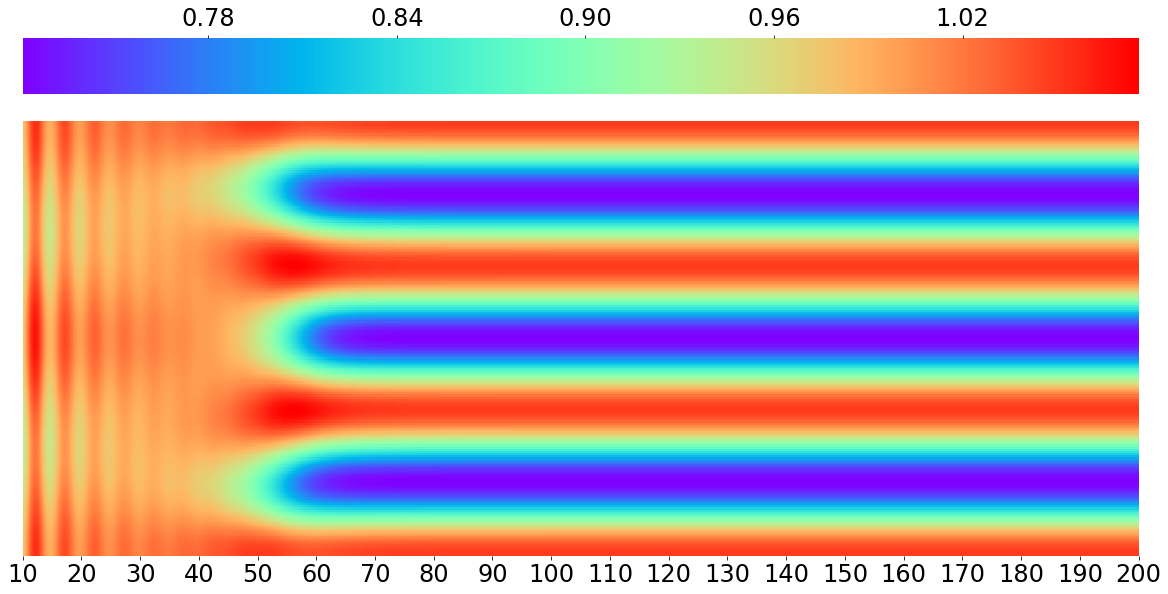

In [102]:
a.draw_heatmap(10,200,19,cmap="rainbow")

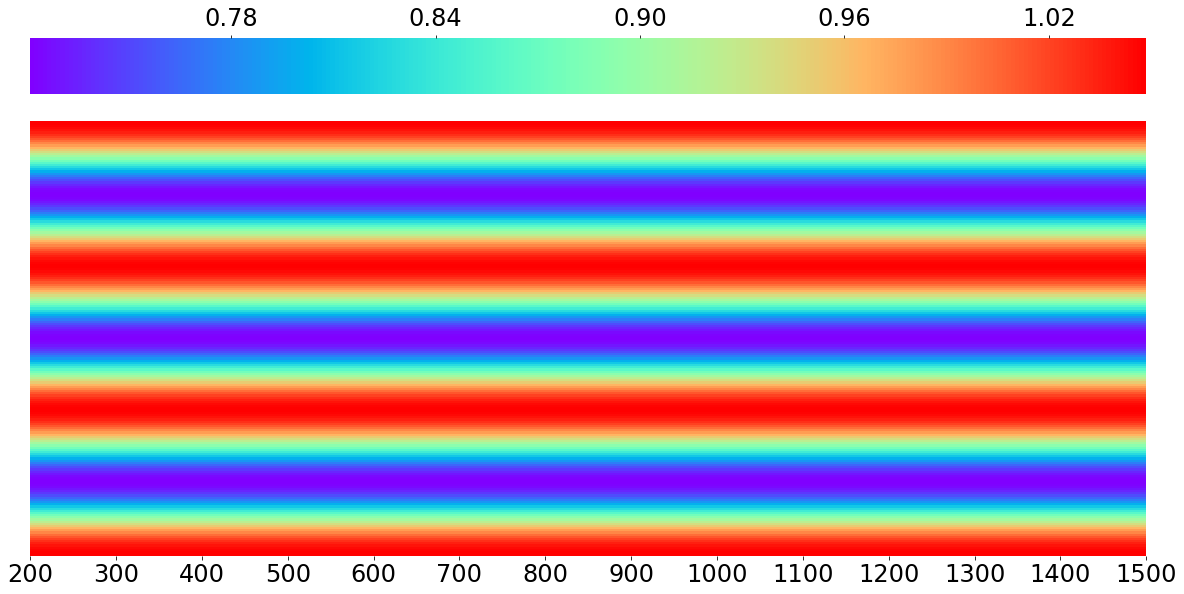

In [103]:
a.draw_heatmap(200,1500,13,cmap="rainbow")

In [57]:
1//0.2

4.0

In [58]:
1/0.2

5.0

ZeroDivisionError: integer division or modulo by zero